In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# Core

> StatsForecast contains highly efficient Python implementations of univariate statistical and econometric forecasting models and parallelization and distributed computation utilities. StatsForecast library contains two main components:<br><br> The first component is a high-level `core.StatsForecast` wrapper class that operates with (potentially large) sets of time series data through pandas DataFrames. The second component comprises low-level model estimator classes like `models.AutoARIMA` and `models.ETS` that operate like sklearn classes with univariate time series NumPy inputs and outputs.


In [ ]:
#| hide
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from nbdev.showdoc import add_docs, show_doc
from statsforecast.models import Naive

In [ ]:
#| export
import inspect
import logging
from os import cpu_count
from typing import Any, List, Optional

import numpy as np
import pandas as pd

In [ ]:
#| exporti
logging.basicConfig(
    format='%(asctime)s %(name)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)
logger = logging.getLogger(__name__)

In [ ]:
#| hide
logger.setLevel(logging.ERROR)

In [ ]:
#| hide
from fastcore.test import test_eq, test_fail
from statsforecast.utils import generate_series

In [ ]:
#| exporti
class GroupedArray:
    
    def __init__(self, data, indptr):
        self.data = data
        self.indptr = indptr
        self.n_groups = self.indptr.size - 1
        
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.data[self.indptr[idx] : self.indptr[idx + 1]]
        elif isinstance(idx, slice):
            idx = slice(idx.start, idx.stop + 1, idx.step)
            new_indptr = self.indptr[idx].copy()
            new_data = self.data[new_indptr[0] : new_indptr[-1]].copy()            
            new_indptr -= new_indptr[0]
            return GroupedArray(new_data, new_indptr)
        raise ValueError(f'idx must be either int or slice, got {type(idx)}')
    
    def __len__(self):
        return self.n_groups
    
    def __repr__(self):
        return f'GroupedArray(n_data={self.data.size:,}, n_groups={self.n_groups:,})'
    
    def __eq__(self, other):
        if not hasattr(other, 'data') or not hasattr(other, 'indptr'):
            return False
        return np.allclose(self.data, other.data) and np.array_equal(self.indptr, other.indptr)
    
    def fit(self, models):
        fm = np.full((self.n_groups, len(models)), np.nan, dtype=object)
        for i, grp in enumerate(self):
            y = grp[:, 0] if grp.ndim == 2 else grp
            X = grp[:, 1:] if (grp.ndim == 2 and grp.shape[1] > 1) else None
            for i_model, model in enumerate(models):
                new_model = model.new()
                fm[i, i_model] = new_model.fit(y=y, X=X)
        return fm
    
    def _get_cols(self, models, attr, h, X, level=tuple()):
        n_models = len(models)
        cuts = np.full(n_models + 1, fill_value=np.nan, dtype=np.int32)
        has_level_models = np.full(n_models, fill_value=False, dtype=bool) 
        cuts[0] = 0
        for i_model, model in enumerate(models):
            len_cols = 1 # mean
            has_level = 'level' in inspect.signature(getattr(model, attr)).parameters and len(level) > 0
            has_level_models[i_model] = has_level
            if has_level:
                len_cols += 2 * len(level) #levels
            cuts[i_model + 1] = len_cols + cuts[i_model]
        return cuts, has_level_models
    
    def _output_fcst(self, models, attr, h, X, level=tuple()):
        #returns empty output according to method
        cuts, has_level_models = self._get_cols(models=models, attr=attr, h=h, X=X, level=level)
        out = np.full((self.n_groups * h, cuts[-1]), fill_value=np.nan, dtype=np.float32)
        return out, cuts, has_level_models
        
    def predict(self, fm, h, X=None, level=tuple()):
        #fm stands for fitted_models
        #and fm should have fitted_model
        fcsts, cuts, has_level_models = self._output_fcst(
            models=fm[0], attr='predict', 
            h=h, X=X, level=level
        )
        matches = ['mean', 'lo', 'hi']
        cols = []
        for i_model in range(fm.shape[1]):
            has_level = has_level_models[i_model]
            kwargs = {}
            if has_level:
                kwargs['level'] = level
            for i, _ in enumerate(self):
                if X is not None:
                    X_ = X[i]
                else:
                    X_ = None
                res_i = fm[i, i_model].predict(h=h, X=X_, **kwargs)
                cols_m = [key for key in res_i.keys() if any(key.startswith(m) for m in matches)]
                fcsts_i = np.vstack([res_i[key] for key in cols_m]).T
                model_name = repr(fm[i, i_model])
                cols_m = [f'{model_name}' if col == 'mean' else f'{model_name}-{col}' for col in cols_m]
                if fcsts_i.ndim == 1:
                    fcsts_i = fcsts_i[:, None]
                fcsts[i * h : (i + 1) * h, cuts[i_model]:cuts[i_model + 1]] = fcsts_i
            cols += cols_m
        return fcsts, cols
    
    def fit_predict(self, models, h, X=None, level=tuple()):
        #fitted models
        fm = self.fit(models=models)
        #forecasts
        fcsts, cols = self.predict(fm=fm, h=h, X=X, level=level)
        return fm, fcsts, cols
    
    def forecast(self, models, h, fitted=False, X=None, level=tuple()):
        fcsts, cuts, has_level_models = self._output_fcst(
            models=models, attr='forecast', 
            h=h, X=X, level=level
        )
        matches = ['mean', 'lo', 'hi']
        if fitted:
            #for the moment we dont return levels for fitted values in 
            #forecast mode
            fitted_vals = np.full((self.data.shape[0], 1 + len(models)), np.nan, dtype=np.float32)
            if self.data.ndim == 1:
                fitted_vals[:, 0] = self.data
            else:
                fitted_vals[:, 0] = self.data[:, 0]
        for i, grp in enumerate(self):
            y_train = grp[:, 0] if grp.ndim == 2 else grp
            X_train = grp[:, 1:] if (grp.ndim == 2 and grp.shape[1] > 1) else None
            if X is not None:
                X_f = X[i]
            else:
                X_f = None
            cols = []
            for i_model, model in enumerate(models):
                has_level = has_level_models[i_model]
                kwargs = {}
                if has_level:
                    kwargs['level'] = level
                res_i = model.forecast(h=h, y=y_train, X=X_train, X_future=X_f, fitted=fitted, **kwargs)
                cols_m = [key for key in res_i.keys() if any(key.startswith(m) for m in matches)]
                fcsts_i = np.vstack([res_i[key] for key in cols_m]).T
                cols_m = [f'{repr(model)}' if col == 'mean' else f'{repr(model)}-{col}' for col in cols_m]
                if fcsts_i.ndim == 1:
                    fcsts_i = fcsts_i[:, None]
                fcsts[i * h : (i + 1) * h, cuts[i_model]:cuts[i_model + 1]] = fcsts_i
                cols += cols_m
                if fitted:
                    fitted_vals[self.indptr[i] : self.indptr[i + 1], i_model + 1] = res_i['fitted']
        result = {'forecasts': fcsts, 'cols': cols}
        if fitted:
            result['fitted'] = {'values': fitted_vals}
            result['fitted']['cols'] = ['y'] + [repr(model) for model in models]
        return result
    
    def cross_validation(self, models, h, test_size, step_size=1, input_size=None, fitted=False, level=tuple()):
        # output of size: (ts, window, h)
        if (test_size - h) % step_size:
            raise Exception('`test_size - h` should be module `step_size`')
        n_windows = int((test_size - h) / step_size) + 1
        n_models = len(models)
        cuts, has_level_models = self._get_cols(models=models, attr='forecast', h=h, X=None, level=level)
        # first column of out is the actual y
        out = np.full((self.n_groups, n_windows, h, 1 + cuts[-1]), np.nan, dtype=np.float32)
        if fitted:
            fitted_vals = np.full((self.data.shape[0], n_windows, n_models + 1), np.nan, dtype=np.float32)
            fitted_idxs = np.full((self.data.shape[0], n_windows), False, dtype=bool)
            last_fitted_idxs = np.full_like(fitted_idxs, False, dtype=bool)
        matches = ['mean', 'lo', 'hi']
        for i_ts, grp in enumerate(self):
            for i_window, cutoff in enumerate(range(-test_size, -h + 1, step_size), start=0):
                end_cutoff = cutoff + h
                in_size_disp = cutoff if input_size is None else input_size 
                y = grp[(cutoff - in_size_disp):cutoff]
                y_train = y[:, 0] if y.ndim == 2 else y
                X_train = y[:, 1:] if (y.ndim == 2 and y.shape[1] > 1) else None
                y_test = grp[cutoff:] if end_cutoff == 0 else grp[cutoff:end_cutoff]
                X_future = y_test[:, 1:] if (y_test.ndim == 2 and y_test.shape[1] > 1) else None
                out[i_ts, i_window, :, 0] = y_test[:, 0] if y.ndim == 2 else y_test
                if fitted:
                    fitted_vals[self.indptr[i_ts] : self.indptr[i_ts + 1], i_window, 0][
                        (cutoff - in_size_disp):cutoff
                    ] = y_train
                    fitted_idxs[self.indptr[i_ts] : self.indptr[i_ts + 1], i_window][
                        (cutoff - in_size_disp):cutoff
                    ] = True
                    last_fitted_idxs[
                        self.indptr[i_ts] : self.indptr[i_ts + 1], i_window
                    ][cutoff-1] = True
                cols = ['y']
                for i_model, model in enumerate(models):
                    has_level = has_level_models[i_model]
                    kwargs = {}
                    if has_level:
                        kwargs['level'] = level
                    res_i = model.forecast(h=h, y=y_train, X=X_train, X_future=X_future, fitted=fitted, **kwargs)
                    cols_m = [key for key in res_i.keys() if any(key.startswith(m) for m in matches)]
                    fcsts_i = np.vstack([res_i[key] for key in cols_m]).T
                    cols_m = [f'{repr(model)}' if col == 'mean' else f'{repr(model)}-{col}' for col in cols_m]
                    out[i_ts, i_window, :, (1 + cuts[i_model]):(1 + cuts[i_model + 1])] = fcsts_i
                    if fitted:
                        fitted_vals[self.indptr[i_ts] : self.indptr[i_ts + 1], i_window, i_model + 1][
                            (cutoff - in_size_disp):cutoff
                        ] = res_i['fitted']
                    cols += cols_m
        result = {'forecasts': out.reshape(-1, 1 + cuts[-1]), 'cols': cols}
        if fitted:
            result['fitted'] = {
                'values': fitted_vals, 
                'idxs': fitted_idxs, 
                'last_idxs': last_fitted_idxs,
                'cols': ['y'] + [repr(model) for model in models]
            }
        return result

    def split(self, n_chunks):
        return [self[x[0] : x[-1] + 1] for x in np.array_split(range(self.n_groups), n_chunks) if x.size]
    
    def split_fm(self, fm, n_chunks):
        return [fm[x[0] : x[-1] + 1] for x in np.array_split(range(self.n_groups), n_chunks) if x.size]

In [ ]:
#| hide
# sum ahead just returns the last value
# added with h future values 
class SumAhead:
    
    def __init__(self):
        pass
    
    def fit(self, y, X):
        self.last_value = y[-1]
        self.fitted_values = np.full(y.size, np.nan, np.float32)
        self.fitted_values[1:] = y[:1]
        return self
    
    def predict(self, h, X=None, level=None):
        mean = self.last_value + np.arange(1, h + 1)
        res = {'mean': mean}
        if level is not None:
            for lv in level:
                res[f'lo-{lv}'] = mean - 1.0
                res[f'hi-{lv}'] = mean + 1.0
        return res
    
    def __repr__(self):
        return 'SumAhead'
    
    def forecast(self, y, h, X=None, X_future=None, fitted=False, level=None):
        mean = y[-1] + np.arange(1, h + 1)
        res = {'mean': mean}
        if fitted:
            fitted_values = np.full(y.size, np.nan, np.float32)
            fitted_values[1:] = y[1:]
            res['fitted'] = fitted_values
        if level is not None:
            for lv in level:
                res[f'lo-{lv}'] = mean - 1.0
                res[f'hi-{lv}'] = mean + 1.0
        return res
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

In [ ]:
#| hide
#data used for tests
data = np.arange(12)
indptr = np.array([0, 4, 8, 12])

# test we can recover the 
# number of series
ga = GroupedArray(data, indptr)
test_eq(len(ga), 3)

#test splits of data
splits = ga.split(2)
test_eq(splits[0], GroupedArray(data[:8], indptr[:3]))
test_eq(splits[1], GroupedArray(data[8:], np.array([0, 4])))

# fitting models for each ts
models = [Naive(), Naive()]
fm = ga.fit(models)
test_eq(fm.shape, (3, 2))
test_eq(len(ga.split_fm(fm, 2)), 2)

# test forecasts
exp_fcsts = np.hstack([2 * [data[i]] for i in indptr[1:] - 1])
fcsts, cols = ga.predict(fm=fm, h=2)
np.testing.assert_equal(
    fcsts,
    np.hstack([exp_fcsts[:, None], exp_fcsts[:, None]]),
)

#test fit and predict pipelie
fm_fp, fcsts_fp, cols_fp = ga.fit_predict(models=models, h=2) 
test_eq(fm_fp.shape, (3, 2))
np.testing.assert_equal(fcsts_fp, fcsts)
np.testing.assert_equal(cols_fp, cols)

#test levels
fm_lv, fcsts_lv, cols_lv = ga.fit_predict(models=models, h=2, level=(50, 90))
test_eq(fcsts_lv.shape, (2 * len(ga), 2)) #for the moment naive doesnt return levels

#test forecast
fcst_f = ga.forecast(models=models, h=2, fitted=True)
test_eq(fcst_f['forecasts'], fcsts_fp)
test_eq(fcst_f['cols'], cols_fp)

In [ ]:
#| hide
#test levels
lv = (50, 60)
h = 2
#test for forecasts
fcsts_lv = ga.forecast(models=[SumAhead()], h=h, fitted=True, level=lv)
test_eq(
    fcsts_lv['forecasts'].shape,
    (len(ga) * h, 1 + 2 * len(lv))
)
test_eq(
    fcsts_lv['cols'],
    ['SumAhead', 
     'SumAhead-lo-50', 
     'SumAhead-hi-50',
     'SumAhead-lo-60',
     'SumAhead-hi-60']
)
#fit and predict pipeline
fm_lv_fp, fcsts_lv_fp, cols_lv_fp = ga.fit_predict(models=[SumAhead()], h=h, level=lv)
test_eq(
    fcsts_lv['forecasts'],
    fcsts_lv_fp
)
test_eq(
    fcsts_lv['cols'],
    cols_lv_fp
)

In [ ]:
#| hide
# tests for cross valiation
data = np.hstack([np.arange(10), np.arange(100, 200), np.arange(20, 40)])
indptr = np.array([0, 10, 110, 130])
ga = GroupedArray(data, indptr)
    
res_cv = ga.cross_validation(models=[SumAhead()], h=2, test_size=5, fitted=True)
fcsts_cv = res_cv['forecasts']
cols_cv = res_cv['cols']
test_eq(
    fcsts_cv[:, cols_cv.index('y')], 
    fcsts_cv[:, cols_cv.index('SumAhead')]
)

#levels
res_cv_lv = ga.cross_validation(models=[SumAhead(), Naive()], h=2, test_size=5, level=(50, 60))

In [ ]:
#| hide
actual_step_size = np.unique(np.diff(fcsts_cv[:, cols_cv.index('SumAhead')].reshape((3, -1, 2)), axis=1))
test_eq(actual_step_size, 1)

In [ ]:
#| hide
horizons = [1, 2, 3, 2]
test_sizes = [3, 4, 6, 6]
step_sizes = [2, 2, 3, 4]
for h, test_size, step_size in zip(horizons, test_sizes, step_sizes):
    res_cv = ga.cross_validation(
        models=[SumAhead()], h=h, 
        test_size=test_size, 
        step_size=step_size,
        fitted=True
    )
    fcsts_cv = res_cv['forecasts']
    cols_cv = res_cv['cols']
    test_eq(
        fcsts_cv[:, cols_cv.index('y')], 
        fcsts_cv[:, cols_cv.index('SumAhead')]
    )
    fcsts_cv = fcsts_cv[:, cols_cv.index('SumAhead')].reshape((3, -1, h))
    actual_step_size = np.unique(
        np.diff(fcsts_cv, axis=1)
    )
    test_eq(actual_step_size, step_size)
    actual_n_windows = res_cv['forecasts'].shape[1]
    test_eq(actual_n_windows, int((test_size - h)/step_size) + 1)

In [ ]:
#| hide 
def fail_cv(h, test_size, step_size):
    return ga.cross_validation(models=[SumAhead()], h=h, test_size=test_size, step_size=step_size)
test_fail(fail_cv, contains='module', kwargs=dict(h=2, test_size=5, step_size=2))

In [ ]:
#| exporti
def _grouped_array_from_df(df, sort_df):
    df = df.set_index('ds', append=True)
    if not df.index.is_monotonic_increasing and sort_df:
        df = df.sort_index()
    data = df.values.astype(np.float32)
    indices_sizes = df.index.get_level_values('unique_id').value_counts(sort=False)
    indices = indices_sizes.index
    sizes = indices_sizes.values
    cum_sizes = sizes.cumsum()
    dates = df.index.get_level_values('ds')[cum_sizes - 1]
    indptr = np.append(0, cum_sizes).astype(np.int32)
    return GroupedArray(data, indptr), indices, dates, df.index

In [ ]:
#| hide
series = generate_series(10_000, n_static_features=2, equal_ends=False)
sorted_series = series.sort_values(['unique_id', 'ds'])
unsorted_series = sorted_series.sample(frac=1.0)
ga, indices, dates, ds = _grouped_array_from_df(unsorted_series, sort_df=True)

np.testing.assert_allclose(ga.data, sorted_series.drop(columns='ds').values)
test_eq(indices, sorted_series.index.unique(level='unique_id'))
test_eq(dates, series.groupby('unique_id')['ds'].max().values)

In [ ]:
#| exporti
def _cv_dates(last_dates, freq, h, test_size, step_size=1):
    #assuming step_size = 1
    if (test_size - h) % step_size:
        raise Exception('`test_size - h` should be module `step_size`')
    n_windows = int((test_size - h) / step_size) + 1
    if len(np.unique(last_dates)) == 1:
        if issubclass(last_dates.dtype.type, np.integer):
            total_dates = np.arange(last_dates[0] - test_size + 1, last_dates[0] + 1)
            out = np.empty((h * n_windows, 2), dtype=last_dates.dtype)
            freq = 1
        else:
            total_dates = pd.date_range(end=last_dates[0], periods=test_size, freq=freq)
            out = np.empty((h * n_windows, 2), dtype='datetime64[s]')
        for i_window, cutoff in enumerate(range(-test_size, -h + 1, step_size), start=0):
            end_cutoff = cutoff + h
            out[h * i_window : h * (i_window + 1), 0] = total_dates[cutoff:] if end_cutoff == 0 else total_dates[cutoff:end_cutoff]
            out[h * i_window : h * (i_window + 1), 1] = np.tile(total_dates[cutoff] - freq, h)
        dates = pd.DataFrame(np.tile(out, (len(last_dates), 1)), columns=['ds', 'cutoff'])
    else:
        dates = pd.concat([_cv_dates(np.array([ld]), freq, h, test_size, step_size) for ld in last_dates])
        dates = dates.reset_index(drop=True)
    return dates

In [ ]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [47, 48, 49],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [46] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5))

In [ ]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5, step_size=2))

In [ ]:
#| hide
for e_e in [True, False]:
    n_series = 2
    ga, indices, dates, ds = _grouped_array_from_df(generate_series(n_series, equal_ends=e_e), sort_df=True)
    freq = pd.tseries.frequencies.to_offset('D')
    horizon = 3
    test_size = 5
    df_dates = _cv_dates(last_dates=dates, freq=freq, h=horizon, test_size=test_size)
    test_eq(len(df_dates), n_series * horizon * (test_size - horizon + 1)) 

In [ ]:
#| exporti
def _get_n_jobs(n_groups, n_jobs, ray_address):
    if ray_address is not None:
        logger.info(
            'Using ray address,'
            'using available resources insted of `n_jobs`'
        )
        try:
            import ray
        except ModuleNotFoundError as e:
            msg = (
                f'{e}. To use a ray cluster you have to install '
                'ray. Please run `pip install ray`. '
            )
            raise ModuleNotFoundError(msg) from e
        if not ray.is_initialized():
            ray.init(ray_address, ignore_reinit_error=True)
        actual_n_jobs = int(ray.available_resources()['CPU'])
    else:
        if n_jobs == -1 or (n_jobs is None):
            actual_n_jobs = cpu_count()
        else:
            actual_n_jobs = n_jobs
    return min(n_groups, actual_n_jobs)

In [ ]:
#| hide
#tests for more series than resources
test_eq(_get_n_jobs(100, -1, None), cpu_count()) 
test_eq(_get_n_jobs(100, None, None), cpu_count())
test_eq(_get_n_jobs(100, 2, None), 2)

In [ ]:
#| hide
#tests for less series than resources
test_eq(_get_n_jobs(1, -1, None), 1) 
test_eq(_get_n_jobs(1, None, None), 1)
test_eq(_get_n_jobs(2, 10, None), 2)

# <span style="color:DarkBlue">1. core.StatsForecast </span>

In [ ]:
#| export
class StatsForecast:
    
    def __init__(
            self, 
            models: List[Any],
            freq: str,
            n_jobs: int = 1,
            ray_address: Optional[str] = None,
            df: Optional[pd.DataFrame] = None,
            sort_df: bool = True
        ):
        """core.StatsForecast.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py).

        The `core.StatsForecast` class allows you to efficiently fit multiple `StatsForecast` models 
        for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
        and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
        time series variable. 

        The class has memory-efficient `StatsForecast.forecast` method that avoids storing partial 
        model outputs. While the `StatsForecast.fit` and `StatsForecast.predict` methods with 
        Scikit-learn interface store the fitted models.

        **Parameters:**<br>
        `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
        `models`: List[typing.Any], list of StatsForecast instantiated models.<br>
        `freq`: str, frequency of the data, [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).<br>
        `n_jobs`: int, number of jobs used in the parallel processing, use -1 for all cores.<br>
        `sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].<br>

        **Notes:**<br>
        The `core.StatsForecast` class offers parallelization utilities with Dask, Spark and Ray back-ends.<br>
        See distributed computing example [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/ray).
        """
        # TODO @fede: needed for residuals, think about it later
        self.models = models
        self.freq = pd.tseries.frequencies.to_offset(freq)
        self.n_jobs = n_jobs
        self.ray_address = ray_address
        self._prepare_fit(df=df, sort_df=sort_df)
        
    def _prepare_fit(self, df, sort_df):
        if df is not None:
            if df.index.name != 'unique_id':
                df = df.set_index('unique_id')
            self.ga, self.uids, self.last_dates, self.ds = _grouped_array_from_df(df, sort_df)
            self.n_jobs = _get_n_jobs(len(self.ga), self.n_jobs, self.ray_address)
            self.sort_df = sort_df
        
    def fit(
            self,
            df: Optional[pd.DataFrame] = None, 
            sort_df: bool = True 
        ):
        """Fit the core.StatsForecast.

        Fit `models` to a large set of time series from DataFrame `df`.
        and store fitted models for later inspection.

        **Parameters:**<br>
        `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
        `sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].<br>

        **Returns:**<br>
        `self`: Returns with stored `StatsForecast` fitted `models`.
        """
        self._prepare_fit(df, sort_df)
        if self.n_jobs == 1:
            self.fitted_ = self.ga.fit(models=self.models)
        else:
            self.fitted_ = self._fit_parallel()
        return self
    
    def _make_future_df(self, h: int):
        if issubclass(self.last_dates.dtype.type, np.integer):
            last_date_f = lambda x: np.arange(x + 1, x + 1 + h, dtype=self.last_dates.dtype)
        else:
            last_date_f = lambda x: pd.date_range(x + self.freq, periods=h, freq=self.freq)
        if len(np.unique(self.last_dates)) == 1:
            dates = np.tile(last_date_f(self.last_dates[0]), len(self.ga))
        else:
            dates = np.hstack([
                last_date_f(last_date)
                for last_date in self.last_dates            
            ])
        idx = pd.Index(np.repeat(self.uids, h), name='unique_id')
        df = pd.DataFrame({'ds': dates}, index=idx)
        return df
    
    def _parse_X_level(self, h, X, level):
        if X is not None:
            if X.index.name != 'unique_id':
                X = X.set_index('unique_id')
            expected_shape = (h * len(self.ga), self.ga.data.shape[1])
            if X.shape != expected_shape:
                raise ValueError(f'Expected X to have shape {expected_shape}, but got {X.shape}')
            X, _, _, _ = _grouped_array_from_df(X, sort_df=self.sort_df)
        if level is None:
            level = tuple()
        return X, level
    
    def predict(
            self,
            h: int,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
        ):
        """Predict with StatsForecast Core.

        Use stored fitted `models` to predict large set of time series from DataFrame `df`.        

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>
        `X_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `fcsts_df`: pandas.DataFrame, with `models` columns for point predictions and probabilistic
        predictions for all fitted `models`.<br>
        """
        X, level = self._parse_X_level(h=h, X=X_df, level=level)
        if self.n_jobs == 1:
            fcsts, cols = self.ga.predict(fm=self.fitted_, h=h, X=X, level=level)
        else:
            fcsts, cols = self._predict_parallel(h=h, X=X, level=level)
        fcsts_df = self._make_future_df(h=h)
        fcsts_df[cols] = fcsts
        return fcsts_df
    
    def fit_predict(
            self,
            h: int,
            df: Optional[pd.DataFrame] = None,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
            sort_df: bool = True
        ):
        """Fit and Predict with core.StatsForecast.

        This method avoids memory burden due from object storage.
        It is analogous to Scikit-Learn `fit_predict` without storing information.
        It requires the forecast horizon `h` in advance. 
        
        In contrast to `StatsForecast.forecast` this method stores partial models outputs.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>
        `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.
        `X_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].

        **Returns:**<br>
        `fcsts_df`: pandas.DataFrame, with `models` columns for point predictions and probabilistic
        predictions for all fitted `models`.<br>
        """
        self._prepare_fit(df, sort_df)
        X, level = self._parse_X_level(h=h, X=X_df, level=level)
        if self.n_jobs == 1:
            self.fitted_, fcsts, cols = self.ga.fit_predict(models=self.models, h=h, X=X, level=level)
        else:
            self.fitted_, fcsts, cols = self._fit_predict_parallel(h=h, X=X, level=level)
        fcsts_df = self._make_future_df(h=h)
        fcsts_df[cols] = fcsts
        return fcsts_df
    
    def forecast(
            self,
            h: int,
            df: Optional[pd.DataFrame] = None,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
            sort_df: bool = True
        ):
        """Memory Efficient core.StatsForecast predictions.

        This method avoids memory burden due from object storage.
        It is analogous to Scikit-Learn `fit_predict` without storing information.
        It requires the forecast horizon `h` in advance.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>
        `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
        `X_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>
        `sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].<br>

        **Returns:**<br>
        `fcsts_df`: pandas.DataFrame, with `models` columns for point predictions and probabilistic
        predictions for all fitted `models`.<br>
        """
        self._prepare_fit(df, sort_df)
        X, level = self._parse_X_level(h=h, X=X_df, level=level)
        if self.n_jobs == 1:
            res_fcsts = self.ga.forecast(models=self.models, h=h, fitted=fitted, X=X, level=level)
        else:
            res_fcsts = self._forecast_parallel(h=h, fitted=fitted, X=X, level=level)
        if fitted:
            self.fcst_fitted_values_ = res_fcsts['fitted']
        fcsts = res_fcsts['forecasts']
        cols = res_fcsts['cols']
        fcsts_df = self._make_future_df(h=h)
        fcsts_df[cols] = fcsts
        return fcsts_df
    
    def forecast_fitted_values(self):
        """Access core.StatsForecast insample predictions.

        After executing `StatsForecast.forecast`, you can access the insample 
        prediction values for each model. To get them, you need to pass `fitted=True` 
        to the `StatsForecast.forecast` method and then use the 
        `StatsForecast.forecast_fitted_values` method.

        **Parameters:**<br>
        Check `StatsForecast.forecast` parameters, use `fitted=True`.<br>

        **Returns:**<br>
        `fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
        predictions for all fitted `models`.<br>
        """
        if not hasattr(self, 'fcst_fitted_values_'):
            raise Exception('Please run `forecast` mehtod using `fitted=True`')
        cols = self.fcst_fitted_values_['cols']
        df = pd.DataFrame(self.fcst_fitted_values_['values'], 
                          columns=cols, 
                          index=self.ds).reset_index(level=1)
        return df

    def cross_validation(
            self,
            h: int,
            df: Optional[pd.DataFrame] = None,
            n_windows: int = 1,
            step_size: int = 1,
            test_size: Optional[int] = None,
            input_size: Optional[int] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
            sort_df: bool = True
        ):
        """Time Series Cross Validation with core.StatsForecast.

        `StatsForecast` allows for the efficient computation of time series cross validation.
        The technique creates multiple training windows and predicts on chained or rolled windows.
        `StatsForecast`'s' speed allows to overcome this evaluation technique high computational
        costs. Its usage allows for better test model's generalization measurements by increasing
        the test's length and diversity.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>
        `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
        `n_windows`: int, number of windows used for cross validation.<br>
        `step_size`: int = 1, step size between each window.<br>
        `test_size`: Optional[int] = None, length of test size. If passed, set `n_windows=None`.<br>
        `input_size`: Optional[int] = None, input size for each window, if not none rolled windows.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>
        `sort_df`: bool, if True, sort `df` by `unique_id` and `ds`.

        **Returns:**<br>
        `fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
        predictions for all fitted `models`.<br>
        """
        if test_size is None:
            test_size = h + step_size * (n_windows - 1)
        elif n_windows is None:
            if (test_size - h) % step_size:
                raise Exception('`test_size - h` should be module `step_size`')
            n_windows = int((test_size - h) / step_size) + 1
        elif (n_windows is None) and (test_size is None):
            raise Exception('you must define `n_windows` or `test_size`')
        else:
            raise Exception('you must define `n_windows` or `test_size` but not both')
        self._prepare_fit(df, sort_df)
        _, level = self._parse_X_level(h=h, X=None, level=level)
        if self.n_jobs == 1:
            res_fcsts = self.ga.cross_validation(
                models=self.models, h=h, test_size=test_size, 
                step_size=step_size, 
                input_size=input_size, 
                fitted=fitted,
                level=level
            )
        else:
            res_fcsts = self._cross_validation_parallel(
                h=h, 
                test_size=test_size,
                step_size=step_size,
                input_size=input_size,
                fitted=fitted,
                level=level
            )
            
        if fitted:
            self.cv_fitted_values_ = res_fcsts['fitted']
            self.n_cv_ = n_windows
            
        fcsts = res_fcsts['forecasts']
        cols = res_fcsts['cols']
        fcsts_df = _cv_dates(last_dates=self.last_dates, freq=self.freq, 
                             h=h, test_size=test_size, step_size=step_size)
        idx = pd.Index(np.repeat(self.uids, h * n_windows), name='unique_id')
        fcsts_df.index = idx
        fcsts_df[cols] = fcsts
        return fcsts_df
    
    def cross_validation_fitted_values(self):
        """Access core.StatsForecast insample cross validated predictions.

        After executing `StatsForecast.cross_validation`, you can access the insample 
        prediction values for each model and window. To get them, you need to pass `fitted=True` 
        to the `StatsForecast.cross_validation` method and then use the 
        `StatsForecast.cross_validation_fitted_values` method.

        **Parameters:**<br>
        Check `StatsForecast.cross_validation` parameters, use `fitted=True`.<br>

        **Returns:**<br>
        `fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
        predictions for all fitted `models`.<br>
        """
        if not hasattr(self, 'cv_fitted_values_'):
            raise Exception('Please run `cross_validation` mehtod using `fitted=True`')
        index = pd.MultiIndex.from_tuples(np.tile(self.ds, self.n_cv_), names=['unique_id', 'ds'])
        df = pd.DataFrame(index=index)
        df['cutoff'] = self.cv_fitted_values_['last_idxs'].flatten(order='F')
        df[self.cv_fitted_values_['cols']] = np.reshape(self.cv_fitted_values_['values'], (-1, len(self.models) + 1), order='F')
        idxs = self.cv_fitted_values_['idxs'].flatten(order='F')
        df = df.iloc[idxs].reset_index(level=1)
        df['cutoff'] = df['ds'].where(df['cutoff']).bfill()
        return df

    def _get_pool(self):
        if self.ray_address is not None:
            try:
                from ray.util.multiprocessing import Pool
            except ModuleNotFoundError as e:
                msg = (
                    f'{e}. To use a ray cluster you have to install '
                    'ray. Please run `pip install ray`. '
                )
                raise ModuleNotFoundError(msg) from e
            pool_kwargs = dict(ray_address=self.ray_address)
        else:
            from multiprocessing import Pool
            pool_kwargs = dict()
        return Pool, pool_kwargs
    
    def _fit_parallel(self):
        gas = self.ga.split(self.n_jobs)
        Pool, pool_kwargs = self._get_pool()
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga in gas:
                future = executor.apply_async(ga.fit, (self.models,))
                futures.append(future)
            fm = np.vstack([f.get() for f in futures])
        return fm
    
    def _get_gas_Xs(self, X):
        gas = self.ga.split(self.n_jobs)
        if X is not None:
            Xs = X.split(self.n_jobs)
        else:
            from itertools import repeat
            Xs = repeat(None)
        return gas, Xs
    
    def _predict_parallel(self, h, X, level):
        #create elements for each core
        gas, Xs = self._get_gas_Xs(X=X)
        fms = self.ga.split_fm(self.fitted_, self.n_jobs)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga, fm, X_ in zip(gas, fms, Xs):
                future = executor.apply_async(ga.predict, (fm, h, X_, level,))
                futures.append(future)
            out = [f.get() for f in futures]
            fcsts, cols = list(zip(*out))
            fcsts = np.vstack(fcsts)
            cols = cols[0]
        return fcsts, cols
    
    def _fit_predict_parallel(self, h, X, level):
        #create elements for each core
        gas, Xs = self._get_gas_Xs(X=X)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga, X_ in zip(gas, Xs):
                future = executor.apply_async(ga.fit_predict, (self.models, h, X_, level,))
                futures.append(future)
            out = [f.get() for f in futures]
            fm, fcsts, cols = list(zip(*out))
            fm = np.vstack(fm)
            fcsts = np.vstack(fcsts)
            cols = cols[0]
        return fm, fcsts, cols
    
    def _forecast_parallel(self, h, fitted, X, level):
        #create elements for each core
        gas, Xs = self._get_gas_Xs(X=X)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        result = {}
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga, X_ in zip(gas, Xs):
                future = executor.apply_async(ga.forecast, (self.models, h, fitted, X_, level,))
                futures.append(future)
            out = [f.get() for f in futures]
            fcsts = [d['forecasts'] for d in out]
            fcsts = np.vstack(fcsts)
            cols = out[0]['cols']
            result['forecasts'] = fcsts
            result['cols'] = cols
            if fitted:
                result['fitted'] = {}
                fitted_vals = [d['fitted']['values'] for d in out]
                result['fitted']['values'] = np.vstack(fitted_vals)
                result['fitted']['cols'] = out[0]['fitted']['cols']
        return result
    
    def _cross_validation_parallel(self, h, test_size, step_size, input_size, fitted, level):
        #create elements for each core
        gas = self.ga.split(self.n_jobs)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        result = {}
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga in gas:
                future = executor.apply_async(
                    ga.cross_validation, 
                    (self.models, h, test_size, step_size, input_size, fitted, level,)
                )
                futures.append(future)
            out = [f.get() for f in futures]
            fcsts = [d['forecasts'] for d in out]
            fcsts = np.vstack(fcsts)
            cols = out[0]['cols']
            result['forecasts'] = fcsts
            result['cols'] = cols
            if fitted:
                result['fitted'] = {}
                result['fitted']['values'] = np.concatenate([d['fitted']['values'] for d in out])
                for key in ['last_idxs', 'idxs']:
                    result['fitted'][key] = np.concatenate([d['fitted'][key] for d in out])
                result['fitted']['cols'] = out[0]['fitted']['cols']
        return result
    
    def __repr__(self):
        return f"StatsForecast(models=[{','.join(map(repr, self.models))}])"

In [ ]:
show_doc(StatsForecast, title_level=3)

---

### StatsForecast

>      StatsForecast (models:List[Any], freq:str, n_jobs:int=1,
>                     ray_address:Optional[str]=None,
>                     df:Optional[pandas.core.frame.DataFrame]=None,
>                     sort_df:bool=True)

core.StatsForecast.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py).

The `core.StatsForecast` class allows you to efficiently fit multiple `StatsForecast` models 
for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
time series variable. 

The class has memory-efficient `StatsForecast.forecast` method that avoids storing partial 
model outputs. While the `StatsForecast.fit` and `StatsForecast.predict` methods with 
Scikit-learn interface store the fitted models.

**Parameters:**<br>
`df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
`models`: List[typing.Any], list of StatsForecast instantiated models.<br>
`freq`: str, frequency of the data, [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).<br>
`n_jobs`: int, number of jobs used in the parallel processing, use -1 for all cores.<br>
`sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].<br>

**Notes:**<br>
The `core.StatsForecast` class offers parallelization utilities with Dask, Spark and Ray back-ends.<br>
See distributed computing example [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/ray).

In [ ]:
# StatsForecast's class usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import generate_series
from statsforecast.models import ( 
    ADIDA,
    AutoARIMA,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    ETS,
    HistoricAverage,
    IMAPA,
    Naive,
    RandomWalkWithDrift,
    SeasonalExponentialSmoothing,
    SeasonalNaive,
    SeasonalWindowAverage,
    SimpleExponentialSmoothing,
    TSB,
    WindowAverage,
)

# Generate synthetic panel DataFrame for example
panel_df = generate_series(n_series=2, equal_ends=False)
panel_df.groupby('unique_id').tail(4)

,ds,y
unique_id,,
0,2000-08-06,1.415524
0,2000-08-07,2.314491
0,2000-08-08,3.436325
0,2000-08-09,4.136771
1,2000-04-03,0.210270
1,2000-04-04,1.278684
1,2000-04-05,2.430276
1,2000-04-06,3.363522


In [ ]:
# Declare list of instantiated StatsForecast estimators to be fitted
# You can try other estimator's hyperparameters
# You can try other methods from the `models.StatsForecast` collection
# Check them here: https://nixtla.github.io/statsforecast/models.html
models=[AutoARIMA(), Naive()] 

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=models,
                     freq='D', n_jobs=1)

# Efficiently predict
fcsts_df = fcst.forecast(h=4, fitted=True)
fcsts_df.groupby('unique_id').tail(4)

,ds,AutoARIMA,Naive
unique_id,,,
0,2000-08-10,3.657097,4.136771
0,2000-08-11,2.963216,4.136771
0,2000-08-12,0.000000,4.136771
0,2000-08-13,0.000000,4.136771
1,2000-04-07,3.066247,3.363522
1,2000-04-08,1.950213,3.363522
1,2000-04-09,1.760009,3.363522
1,2000-04-10,1.130382,3.363522


## <span style="color:DarkBlue">1.1 Memory Efficient Methods </span>

In [ ]:
show_doc(StatsForecast.forecast, title_level=3)

---

### StatsForecast.forecast

>      StatsForecast.forecast (h:int,
>                              df:Optional[pandas.core.frame.DataFrame]=None,
>                              X_df:Optional[pandas.core.frame.DataFrame]=None,
>                              level:Optional[List[int]]=None,
>                              fitted:bool=False, sort_df:bool=True)

Memory Efficient core.StatsForecast predictions.

This method avoids memory burden due from object storage.
It is analogous to Scikit-Learn `fit_predict` without storing information.
It requires the forecast horizon `h` in advance.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
`X_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>
`sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].<br>

**Returns:**<br>
`fcsts_df`: pandas.DataFrame, with `models` columns for point predictions and probabilistic
predictions for all fitted `models`.<br>

In [ ]:
# StatsForecast.forecast method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import AutoARIMA, Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[AutoARIMA(), Naive()],
                     freq='D', n_jobs=1)

# Efficiently predict without storing memory
fcsts_df = fcst.forecast(h=4, fitted=True)
fcsts_df.groupby('unique_id').tail(4)

,ds,AutoARIMA,Naive
unique_id,,,
1.0,1961-01-01,476.006500,432.0
1.0,1961-01-02,482.846222,432.0
1.0,1961-01-03,512.423523,432.0
1.0,1961-01-04,502.038269,432.0


In [ ]:
#| hide
series = generate_series(100, n_static_features=2, equal_ends=False)

models = [
    ADIDA(), CrostonClassic(), CrostonOptimized(),
    CrostonSBA(), HistoricAverage(), 
    IMAPA(), Naive(), 
    RandomWalkWithDrift(), 
    SeasonalExponentialSmoothing(season_length=7, alpha=0.1),
    SeasonalNaive(season_length=7),
    SeasonalWindowAverage(season_length=7, window_size=4),
    SimpleExponentialSmoothing(alpha=0.1),
    TSB(alpha_d=0.1, alpha_p=0.3),
    WindowAverage(window_size=4)
]

fcst = StatsForecast(
    df=series,
    models=models,
    freq='D',
    n_jobs=1
)

res = fcst.forecast(h=14)

fcst_no_idx = StatsForecast(
    df=series.reset_index(),
    models=models,
    freq='D',
)
test_eq(
    fcst_no_idx.forecast(h=14),
    res
)

In [ ]:
#| hide
test_eq(res.index.unique(), fcst.uids)
last_dates = series.groupby('unique_id')['ds'].max()
test_eq(res.groupby('unique_id')['ds'].min().values, last_dates + pd.offsets.Day())
test_eq(res.groupby('unique_id')['ds'].max().values, last_dates + 14 * pd.offsets.Day())

In [ ]:
#| hide
#test for equal ends time series
series_eq_ends = generate_series(100, equal_ends=True)

fcst = StatsForecast(
    models=models,
    freq='D',
)
res = fcst.forecast(df=series_eq_ends, h=14)

test_eq(res.index.unique(), fcst.uids)
last_dates = series_eq_ends.groupby('unique_id')['ds'].max()
test_eq(res.groupby('unique_id')['ds'].min().values, last_dates + pd.offsets.Day())
test_eq(res.groupby('unique_id')['ds'].max().values, last_dates + 14 * pd.offsets.Day())

In [ ]:
#| hide
#tests for monthly data
monthly_series = generate_series(10_000, freq='M', min_length=10, max_length=20, equal_ends=True)
monthly_series

fcst = StatsForecast(
    models=[Naive()],
    freq='M'
)
monthly_res = fcst.forecast(df=monthly_series, h=4)
monthly_res

last_dates = monthly_series.groupby('unique_id')['ds'].max()
test_eq(monthly_res.groupby('unique_id')['ds'].min().values, fcst.last_dates + pd.offsets.MonthEnd())
test_eq(monthly_res.groupby('unique_id')['ds'].max().values, fcst.last_dates + 4 * pd.offsets.MonthEnd())

In [ ]:
show_doc(StatsForecast.forecast_fitted_values, title_level=3)

---

### StatsForecast.forecast_fitted_values

>      StatsForecast.forecast_fitted_values ()

Access core.StatsForecast insample predictions.

After executing `StatsForecast.forecast`, you can access the insample 
prediction values for each model. To get them, you need to pass `fitted=True` 
to the `StatsForecast.forecast` method and then use the 
`StatsForecast.forecast_fitted_values` method.

**Parameters:**<br>
Check `StatsForecast.forecast` parameters, use `fitted=True`.<br>

**Returns:**<br>
`fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
predictions for all fitted `models`.<br>

In [ ]:
# StatsForecast.forecast_fitted_values method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[Naive()],
                     freq='D', n_jobs=1)

# Access insample predictions
fcsts_df = fcst.forecast(h=12, fitted=True)
insample_fcsts_df = fcst.forecast_fitted_values()
insample_fcsts_df.tail(4)

,ds,y,Naive
unique_id,,,
1.0,1960-09-30,508.0,606.0
1.0,1960-10-31,461.0,508.0
1.0,1960-11-30,390.0,461.0
1.0,1960-12-31,432.0,390.0


In [ ]:
#| hide
#tests for fitted values
def test_fcst_fitted(n_jobs=1):
    fitted_fcst = StatsForecast(
        df=series,
        models=[Naive()],
        freq='D',
        n_jobs=n_jobs,
    )
    fitted_res = fitted_fcst.forecast(14, fitted=True)
    fitted = fitted_fcst.forecast_fitted_values()
    test_eq(series['ds'], fitted['ds'])
    test_eq(series['y'].astype(np.float32), fitted['y'])
test_fcst_fitted()

In [ ]:
show_doc(StatsForecast.cross_validation, title_level=3)

---

### StatsForecast.cross_validation

>      StatsForecast.cross_validation (h:int,
>                                      df:Optional[pandas.core.frame.DataFrame]=
>                                      None, n_windows:int=1, step_size:int=1,
>                                      test_size:Optional[int]=None,
>                                      input_size:Optional[int]=None,
>                                      level:Optional[List[int]]=None,
>                                      fitted:bool=False, sort_df:bool=True)

Time Series Cross Validation with core.StatsForecast.

`StatsForecast` allows for the efficient computation of time series cross validation.
The technique creates multiple training windows and predicts on chained or rolled windows.
`StatsForecast`'s' speed allows to overcome this evaluation technique high computational
costs. Its usage allows for better test model's generalization measurements by increasing
the test's length and diversity.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
`n_windows`: int, number of windows used for cross validation.<br>
`step_size`: int = 1, step size between each window.<br>
`test_size`: Optional[int] = None, length of test size. If passed, set `n_windows=None`.<br>
`input_size`: Optional[int] = None, input size for each window, if not none rolled windows.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>
`sort_df`: bool, if True, sort `df` by `unique_id` and `ds`.

**Returns:**<br>
`fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
predictions for all fitted `models`.<br>

In [ ]:
# StatsForecast.crossvalidation method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[Naive()],
                     freq='D', n_jobs=1)

# Access insample predictions
rolled_fcsts_df = fcst.cross_validation(14, n_windows=2)
rolled_fcsts_df.head(4)

,ds,cutoff,y,Naive
unique_id,,,,
1.0,1960-12-17,1960-12-16,407.0,463.0
1.0,1960-12-18,1960-12-16,362.0,463.0
1.0,1960-12-19,1960-12-16,405.0,463.0
1.0,1960-12-20,1960-12-16,417.0,463.0


In [ ]:
#| hide
#test for cross_validation
series_cv = pd.DataFrame({
    'ds': np.hstack([
        pd.date_range(end='2021-01-01', freq='D', periods=10),
        pd.date_range(end='2022-01-01', freq='D', periods=100),
        pd.date_range(end='2020-01-01', freq='D', periods=20)
    ]),
    'y': np.hstack([np.arange(10.), np.arange(100, 200), np.arange(20, 40)])
}, index=pd.Index(
    data=np.hstack([np.zeros(10), np.zeros(100) + 1, np.zeros(20) + 2]),
    name='unique_id'
))

fcst = StatsForecast(
    df=series_cv,
    models=[SumAhead(), Naive()],
    freq='D'
)
res_cv = fcst.cross_validation(h=2, test_size=5, n_windows=None, level=(50, 60))
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=2, n_windows=2).groupby('unique_id').size().unique()
test_eq(n_windows, 2 * 2)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=3, n_windows=3, step_size=3, fitted=True).groupby('unique_id').size().unique()
test_eq(n_windows, 3 * 3)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

In [ ]:
#| hide
#test for equal ends cross_validation
series_cv = pd.DataFrame({
    'ds': np.hstack([
        pd.date_range(end='2022-01-01', freq='D', periods=10),
        pd.date_range(end='2022-01-01', freq='D', periods=100),
        pd.date_range(end='2022-01-01', freq='D', periods=20)
    ]),
    'y': np.hstack([np.arange(10), np.arange(100, 200), np.arange(20, 40)])
}, index=pd.Index(
    data=np.hstack([np.zeros(10), np.zeros(100) + 1, np.zeros(20) + 2]),
    name='unique_id'
))
fcst = StatsForecast(
    models=[SumAhead()],
    freq='D',
)
res_cv = fcst.cross_validation(df=series_cv, h=2, test_size=5, n_windows=None, level=(50,60), fitted=True)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=2, n_windows=2).groupby('unique_id').size().unique()
test_eq(n_windows, 2 * 2)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=3, n_windows=3, step_size=3).groupby('unique_id').size().unique()
test_eq(n_windows, 3 * 3)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

In [ ]:
show_doc(StatsForecast.cross_validation_fitted_values)

---

### StatsForecast.cross_validation_fitted_values

>      StatsForecast.cross_validation_fitted_values ()

Access core.StatsForecast insample cross validated predictions.

After executing `StatsForecast.cross_validation`, you can access the insample 
prediction values for each model and window. To get them, you need to pass `fitted=True` 
to the `StatsForecast.cross_validation` method and then use the 
`StatsForecast.cross_validation_fitted_values` method.

**Parameters:**<br>
Check `StatsForecast.cross_validation` parameters, use `fitted=True`.<br>

**Returns:**<br>
`fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
predictions for all fitted `models`.<br>

In [ ]:
# StatsForecast.cross_validation_fitted_values method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[Naive()],
                     freq='D', n_jobs=1)

# Access insample predictions
rolled_fcsts_df = fcst.cross_validation(h=12, n_windows=2, fitted=True)
insample_rolled_fcsts_df = fcst.cross_validation_fitted_values()
insample_rolled_fcsts_df.tail(4)

,ds,cutoff,y,Naive
unique_id,,,,
1.0,1959-09-30,1959-12-31,463.0,559.0
1.0,1959-10-31,1959-12-31,407.0,463.0
1.0,1959-11-30,1959-12-31,362.0,407.0
1.0,1959-12-31,1959-12-31,405.0,362.0


In [ ]:
#| hide
#tests for fitted values cross_validation
def test_cv_fitted(n_jobs=1):
    resids_fcst = StatsForecast(
        df=series_cv,
        models=[SumAhead(), Naive()],
        freq='D',
        n_jobs=n_jobs
    )
    resids_res_cv = resids_fcst.cross_validation(h=2, n_windows=4, fitted=True)
    resids_cv = resids_fcst.cross_validation_fitted_values()
    np.testing.assert_array_equal(
        resids_cv['cutoff'].unique(),
        resids_res_cv['cutoff'].unique()
    )
    for uid in resids_cv.index.unique():
        for cutoff in resids_cv.loc[uid]['cutoff'].unique():
            pd.testing.assert_frame_equal(
                resids_cv.loc[uid].query('cutoff == @cutoff')[['ds', 'y']], 
                series_cv.query('ds <= @cutoff & unique_id == @uid')[['ds', 'y']],
                check_dtype=False
            )
test_cv_fitted()

## <span style="color:DarkBlue">1.2 Scikit-Learn-like Methods </span>

In [ ]:
show_doc(StatsForecast.fit, title_level=3)

---

### StatsForecast.fit

>      StatsForecast.fit (df:Optional[pandas.core.frame.DataFrame]=None,
>                         sort_df:bool=True)

Fit the core.StatsForecast.

Fit `models` to a large set of time series from DataFrame `df`.
and store fitted models for later inspection.

**Parameters:**<br>
`df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
`sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].<br>

**Returns:**<br>
`self`: Returns with stored `StatsForecast` fitted `models`.

In [ ]:
#| hide
fcst = fcst.fit(df=series)

In [ ]:
show_doc(StatsForecast.predict, title_level=3)

---

### StatsForecast.predict

>      StatsForecast.predict (h:int,
>                             X_df:Optional[pandas.core.frame.DataFrame]=None,
>                             level:Optional[List[int]]=None)

Predict with StatsForecast Core.

Use stored fitted `models` to predict large set of time series from DataFrame `df`.        

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`X_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`fcsts_df`: pandas.DataFrame, with `models` columns for point predictions and probabilistic
predictions for all fitted `models`.<br>

In [ ]:
#| hide
test_eq(
    fcst.predict(h=12),
    fcst.forecast(h=12)
)

In [ ]:
show_doc(StatsForecast.fit_predict, title_level=3)

---

### StatsForecast.fit_predict

>      StatsForecast.fit_predict (h:int,
>                                 df:Optional[pandas.core.frame.DataFrame]=None,
>                                 X_df:Optional[pandas.core.frame.DataFrame]=Non
>                                 e, level:Optional[List[int]]=None,
>                                 sort_df:bool=True)

Fit and Predict with core.StatsForecast.

This method avoids memory burden due from object storage.
It is analogous to Scikit-Learn `fit_predict` without storing information.
It requires the forecast horizon `h` in advance. 

In contrast to `StatsForecast.forecast` this method stores partial models outputs.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.
`X_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`sort_df`: bool, if True, sort `df` by [`unique_id`,`ds`].

**Returns:**<br>
`fcsts_df`: pandas.DataFrame, with `models` columns for point predictions and probabilistic
predictions for all fitted `models`.<br>

In [ ]:
#| hide
test_eq(
    fcst.fit_predict(h=12),
    fcst.forecast(h=12)
)

In [ ]:
#| hide
#| eval: false

# tests for parallel processing
fcst = StatsForecast(
    df=series,
    models=[ADIDA(), SimpleExponentialSmoothing(0.1), 
            HistoricAverage(), CrostonClassic()],
    freq='D',
    n_jobs=-1
)
res = fcst.forecast(14)
res_cv = fcst.cross_validation(h=3, test_size=10, n_windows=None)
print(res)
print(res_cv)
fcst = StatsForecast(
    df=series_cv,
    models=[SumAhead()],
    freq='D',
)
res_cv = fcst.cross_validation(h=2, test_size=5, n_windows=None)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

test_fcst_fitted(n_jobs=-1)
test_cv_fitted(n_jobs=-1)
# check n_windows argument
n_windows = fcst.cross_validation(h=2, n_windows=2).groupby('unique_id').size().unique()
test_eq(n_windows, 2 * 2)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))
# check step_size argument
n_windows = fcst.cross_validation(h=3, n_windows=3, step_size=3).groupby('unique_id').size().unique()
test_eq(n_windows, 3 * 3)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

                  ds      ADIDA        SES  HistoricAverage  CrostonClassic
unique_id                                                                  
0         2000-08-10  98.980743  98.980743       100.300842       98.980743
0         2000-08-11  98.980743  98.980743       100.300842       98.980743
0         2000-08-12  98.980743  98.980743       100.300842       98.980743
0         2000-08-13  98.980743  98.980743       100.300842       98.980743
0         2000-08-14  98.980743  98.980743       100.300842       98.980743
...              ...        ...        ...              ...             ...
99        2000-07-09  43.281136  43.281136        45.309723       43.281136
99        2000-07-10  43.281136  43.281136        45.309723       43.281136
99        2000-07-11  43.281136  43.281136        45.309723       43.281136
99        2000-07-12  43.281136  43.281136        45.309723       43.281136
99        2000-07-13  43.281136  43.281136        45.309723       43.281136

[1400 rows 

# <span style="color:DarkBlue">2. StatsForecast Examples </span>

## Integer datestamp

The `StatsForecast` class can also receive integers as datestamp, the following example shows how to do it.

In [ ]:
from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengers as ap
from statsforecast.models import HistoricAverage

In [ ]:
int_ds_df = pd.DataFrame({'ds': np.arange(1, len(ap) + 1), 'y': ap})
int_ds_df.insert(0, 'unique_id', 'AirPassengers')
int_ds_df.set_index('unique_id', inplace=True)
int_ds_df.head()

,ds,y
unique_id,,
AirPassengers,1,112.0
AirPassengers,2,118.0
AirPassengers,3,132.0
AirPassengers,4,129.0
AirPassengers,5,121.0


In [ ]:
int_ds_df.tail()

,ds,y
unique_id,,
AirPassengers,140,606.0
AirPassengers,141,508.0
AirPassengers,142,461.0
AirPassengers,143,390.0
AirPassengers,144,432.0


In [ ]:
fcst = StatsForecast(df=int_ds_df, models=[HistoricAverage()], freq='D')
horizon = 7
forecast = fcst.forecast(horizon)
forecast.head()

,ds,HistoricAverage
unique_id,,
AirPassengers,145,280.298615
AirPassengers,146,280.298615
AirPassengers,147,280.298615
AirPassengers,148,280.298615
AirPassengers,149,280.298615


In [ ]:
last_date = int_ds_df['ds'].max()
test_eq(forecast['ds'].values, np.arange(last_date + 1, last_date + 1 + horizon))

In [ ]:
int_ds_cv = fcst.cross_validation(h=7, test_size=8, n_windows=None)
int_ds_cv

,ds,cutoff,y,HistoricAverage
unique_id,,,,
AirPassengers,137,136,472.0,267.183838
AirPassengers,138,136,535.0,267.183838
AirPassengers,139,136,622.0,267.183838
AirPassengers,140,136,606.0,267.183838
AirPassengers,141,136,508.0,267.183838
AirPassengers,142,136,461.0,267.183838
AirPassengers,143,136,390.0,267.183838
AirPassengers,138,137,535.0,268.678833
AirPassengers,139,137,622.0,268.678833


## External regressors

Every column after **y** is considered an external regressor and will be passed to the models that allow them. If you use them you must supply the future values to the `StatsForecast.forecast` method.

In [ ]:
class LinearRegression:
    
    def __init__(self):
        pass
    
    def fit(self, y, X):
        self.coefs_, *_ = np.linalg.lstsq(X, y, rcond=None)
        return self
    
    def predict(self, h, X):
        mean = X @ coefs
        return mean
    
    def __repr__(self):
        return 'LinearRegression()'
    
    def forecast(self, y, h, X=None, X_future=None, fitted=False):
        coefs, *_ = np.linalg.lstsq(X, y, rcond=None)
        return {'mean': X_future @ coefs}
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

In [ ]:
series_xreg = series = generate_series(10_000, equal_ends=True)
series_xreg['intercept'] = 1
series_xreg['dayofweek'] = series_xreg['ds'].dt.dayofweek
series_xreg = pd.get_dummies(series_xreg, columns=['dayofweek'], drop_first=True)
series_xreg

,ds,y,intercept,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
unique_id,,,,,,,,,
0,2000-10-05,0.123838,1,0,0,1,0,0,0
0,2000-10-06,1.460113,1,0,0,0,1,0,0
0,2000-10-07,2.418577,1,0,0,0,0,1,0
0,2000-10-08,3.372232,1,0,0,0,0,0,1
0,2000-10-09,4.241948,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9999,2001-05-10,2.338823,1,0,0,1,0,0,0
9999,2001-05-11,3.402687,1,0,0,0,1,0,0
9999,2001-05-12,4.235569,1,0,0,0,0,1,0


In [ ]:
dates = sorted(series_xreg['ds'].unique())
valid_start = dates[-14]
train_mask = series_xreg['ds'] < valid_start
series_train = series_xreg[train_mask]
series_valid = series_xreg[~train_mask]
X_valid = series_valid.drop(columns=['y'])
fcst = StatsForecast(
    df=series_train,
    models=[LinearRegression()],
    freq='D',
)
xreg_res = fcst.forecast(14, X_df=X_valid)
xreg_res['y'] = series_valid['y'].values

<AxesSubplot:xlabel='ds'>

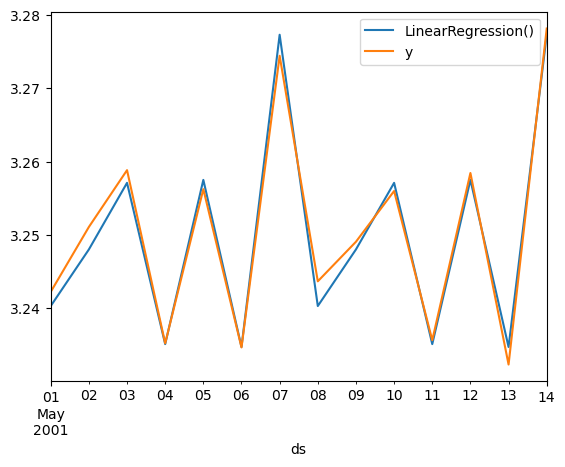

In [ ]:
xreg_res.groupby('ds').mean().plot()

In [ ]:
xreg_res_cv = fcst.cross_validation(h=3, test_size=5, n_windows=None)

In [ ]:
#| hide
# the following cells contain tests for external regressors

In [ ]:
#| hide
class ReturnX:
    
    def __init__(self):
        pass
    
    def fit(self, y, X):
        return self
    
    def predict(self, h, X):
        mean = X
        return X
    
    def __repr__(self):
        return 'ReturnX'
    
    def forecast(self, y, h, X=None, X_future=None, fitted=False):
        return {'mean': X_future.flatten()}
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

In [ ]:
#| hide
df = pd.DataFrame(
    {
        'ds': np.hstack([np.arange(10), np.arange(10)]),
        'y': np.random.rand(20),
        'x': np.arange(20, dtype=np.float32),
    },
    index=pd.Index([0] * 10 + [1] * 10, name='unique_id'),
)
train_mask = df['ds'] < 6
train_df = df[train_mask]
test_df = df[~train_mask]

In [ ]:
#| hide
def test_x_vars(n_jobs=1):
    fcst = StatsForecast(
        df=train_df,
        models=[ReturnX()],
        freq='M',
        n_jobs=n_jobs,
    )
    xreg = test_df.drop(columns='y')
    res = fcst.forecast(4, X_df=xreg)
    expected_res = xreg.rename(columns={'x': 'ReturnX'})
    pd.testing.assert_frame_equal(res, expected_res, check_dtype=False)
test_x_vars(n_jobs=1)

In [ ]:
#| hide
#| eval: false
test_x_vars(n_jobs=2)

## Confidence intervals

You can pass the argument `level` to the `StatsForecast.forecast` method to calculate confidence intervals. Not all models can calculate them at the moment, so we will only obtain the intervals of those models that have it implemented. 

<AxesSubplot:xlabel='ds'>

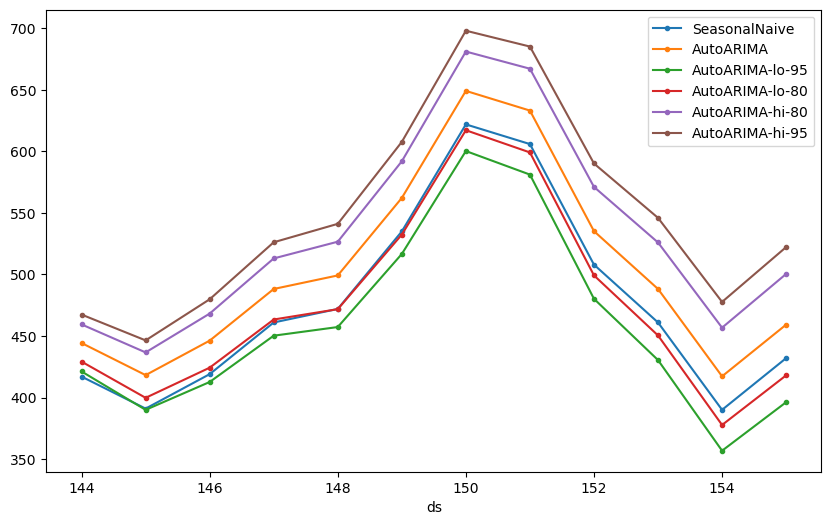

In [ ]:
ap_df = pd.DataFrame({'ds': np.arange(ap.size), 'y': ap}, index=pd.Index([0] * ap.size, name='unique_id'))
fcst = StatsForecast(
    df=ap_df,
    models=[
        SeasonalNaive(season_length=12), 
        AutoARIMA(season_length=12)
    ],
    freq='M',
    n_jobs=1
)
ap_ci = fcst.forecast(12, level=(80, 95))
ap_ci.set_index('ds').plot(marker='.', figsize=(10, 6))

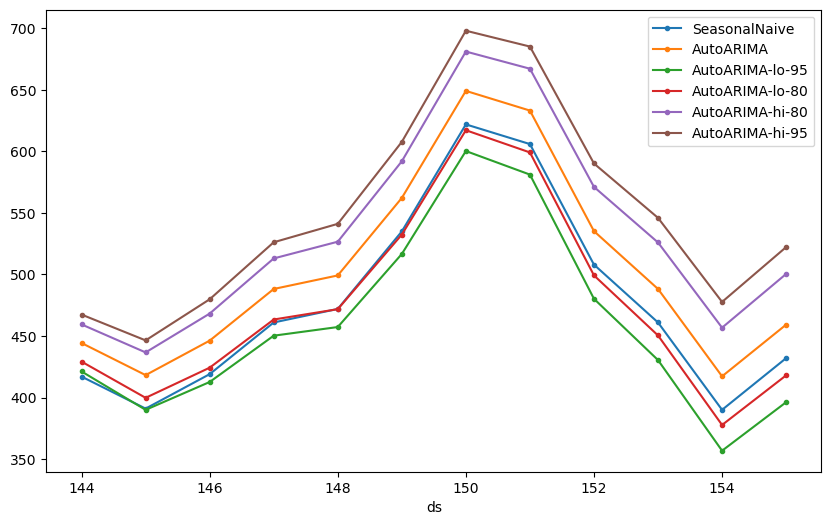

In [ ]:
#hide
def test_conf_intervals(n_jobs=1):
    ap_df = pd.DataFrame({'ds': np.arange(ap.size), 'y': ap}, index=pd.Index([0] * ap.size, name='unique_id'))
    fcst = StatsForecast(
        df=ap_df,
        models=[
            SeasonalNaive(season_length=12), 
            AutoARIMA(season_length=12)
        ],
        freq='M',
        n_jobs=n_jobs
    )
    ap_ci = fcst.forecast(12, level=(80, 95))
    ap_ci.set_index('ds').plot(marker='.', figsize=(10, 6))
test_conf_intervals(n_jobs=1)

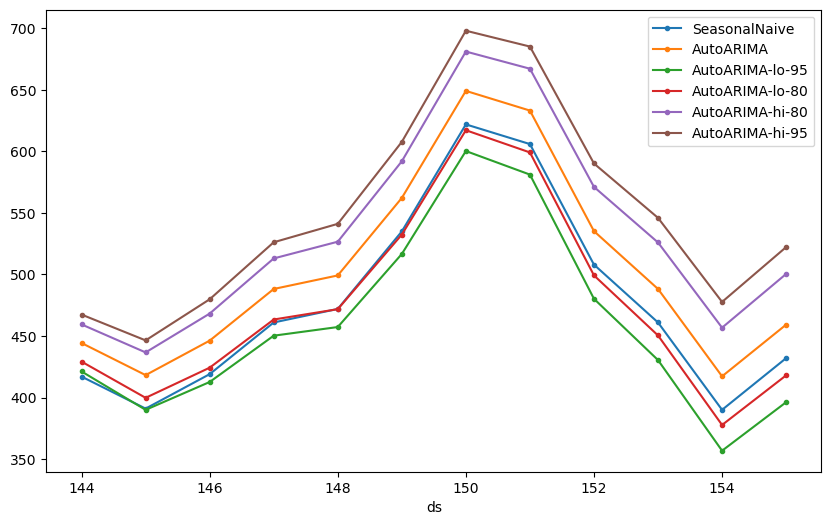

In [ ]:
#| hide
#| eval: false
#test number of jobs greater than the available cores
test_conf_intervals(n_jobs=101)